# Game of Life
This is our week 6 examples notebook and will be available on Github from the powderflask/cap-comp215 repository.
As usual, the first code block just imports the modules we will use.

In [271]:
import re
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

## 2D Elementary Cellular Automata
The state of our CA is now a 2D matrix, but we continue to restrict values in each cell to $0$ or $1$

In [272]:
ca_state = np.random.randint(2, size=(10, 10), dtype=np.uint8)
ca_state

array([[1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 1, 1, 1, 0, 0, 1]], dtype=uint8)

And the "neighbourhood" of a cell is now a $3 x 3$ matrix sometimes called the [Moore Neighbourhood](https://en.wikipedia.org/wiki/Moore_neighborhood)

In [273]:
kernel = np.array(
    [
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ]
)
kernel

array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]])

### Correlation (Sliding Dot-Product) in 2D
We encode the rules for Game of Life using a 2D [kernel](https://en.wikipedia.org/wiki/Kernel_(image_processing)) (which is just a 2D analog to the 1D "window" we used for 1D CAs).
The `kernel` defined above simply **counts** the number of "live" neighbours.  Can you see why?

In [274]:
neighbour_count = correlate2d(ca_state, kernel, mode='same')
neighbour_count

array([[1, 2, 1, 2, 3, 2, 2, 2, 3, 1],
       [2, 3, 2, 2, 4, 6, 5, 4, 2, 2],
       [2, 2, 3, 4, 3, 3, 2, 4, 4, 3],
       [2, 3, 2, 3, 3, 4, 5, 4, 4, 2],
       [2, 4, 4, 2, 3, 3, 4, 4, 6, 3],
       [4, 5, 6, 4, 5, 4, 5, 5, 4, 1],
       [3, 4, 5, 4, 4, 5, 4, 4, 3, 2],
       [3, 5, 7, 6, 5, 4, 3, 5, 2, 1],
       [2, 3, 4, 5, 4, 5, 4, 3, 3, 2],
       [1, 4, 3, 5, 3, 3, 2, 2, 2, 0]])

## Rules of Life
The rules are very simple:
  1. if a cell is alive, it remains alive if it has 2 or 3 live neighbours, otherwise it dies;
  2. if a cell is dead, it stays dead unless it has **exactly** 3 neighbours

In [275]:
next_state = (neighbour_count==3) | (neighbour_count==2) & ca_state
next_state

array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
       [1, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 0, 0, 0]], dtype=uint8)

`numpy.array` is doing a lot of work for us above by performing both $matrix \times scalar$ operations (e.g., check each cell for equality and produce a 2D matrix of `bool`) and $matrix \times matrix$ operations (e.g., apply `or` and `and` operations to pairs of boolean matricies).

### 2D Correlation with a 2D Kernel and 19 state lookup table (0 - 18)
Notice the number of neighbours above can range from $0$ to $8$, so we could use a kernel that counts the centre cell as $10$ to get unique state values ranging from $0$ to $18$
In this case, the centre cell will be alive in the next generation if the correlation result is $3$ (rule 2) or $12$ or $13$ (rule 1)
Just like in the 1D case, we can make the calculation more efficient by "pre-computing" each possible transition in a lookup table.
Thus, we get...

In [276]:
life_kernel = np.array(
    [
        [1, 1, 1],
        [1,10, 1],
        [1, 1, 1]
    ]
)

life_transitions = np.array([0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0])

indexes = correlate2d(ca_state, life_kernel, mode='same')
new_state = life_transitions[indexes]
print(ca_state)
print(indexes)
print(new_state)

[[1 0 0 0 0 1 1 1 0 1]
 [1 0 0 1 1 0 0 0 1 0]
 [0 1 0 0 1 1 1 0 0 0]
 [0 0 1 0 0 0 0 1 1 1]
 [1 0 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 1 0 0 1]
 [1 1 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 1 0 1 0]
 [0 1 1 1 1 0 0 1 0 0]
 [1 0 1 0 1 1 1 0 0 1]]
[[11  2  1  2  3 12 12 12  3 11]
 [12  3  2 12 14  6  5  4 12  2]
 [ 2 12  3  4 13 13 12  4  4  3]
 [ 2  3 12  3  3  4  5 14 14 12]
 [12  4  4 12  3  3 14 14  6 13]
 [14 15  6 14  5 14 15  5  4 11]
 [13 14 15 14 14  5 14 14  3  2]
 [ 3  5  7 16  5  4 13  5 12  1]
 [ 2 13 14 15 14  5  4 13  3  2]
 [11  4 13  5 13 13 12  2  2 10]]
[[0 0 0 0 1 1 1 1 1 0]
 [1 1 0 1 0 0 0 0 1 0]
 [0 1 1 0 1 1 1 0 0 1]
 [0 1 1 1 1 0 0 0 0 1]
 [1 0 0 1 1 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 1 0 1 0]
 [0 1 0 0 0 0 0 1 1 0]
 [0 0 1 0 1 1 1 0 0 0]]


## Display CA as 2-D image

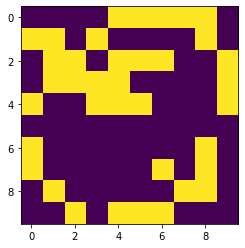

In [277]:
plt.imshow(new_state)

as usual, let's tidy that up a bit and wrap it in an abstraction for re-use...

In [278]:
def plot_2D_array(array, title=''):
    """ Plot the 2D array as an image.  1's will be dark blue, 0's will be light blue. """
    plt.title(title)
    plt.xticks([])  # remove axes tick marks
    plt.yticks([])
    plt.imshow(array, cmap='Blues', interpolation='none')

## A simple Game of Life class
As usual, let's package up what we've developed so far into a small re-usable class.

In [279]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1,10, 1],
                       [1, 1, 1]])

    rules = np.zeros(19, dtype=np.uint8)
    rules[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.random.randint(2, size=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same')
        self.state = self.rules[transitions]

    def draw(self, step=''):
        plot_2D_array(self.state, f"Conway's Game of Life {step}")

and a small test to show how `Life2D` works...

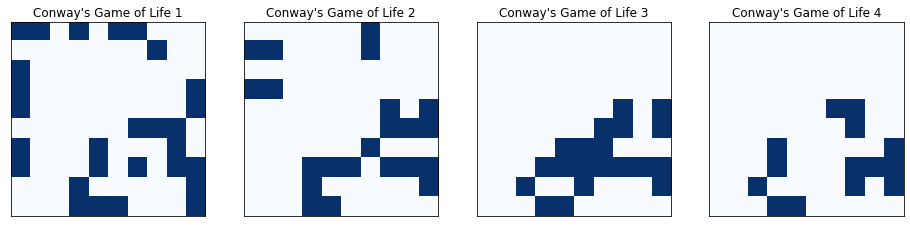

In [284]:
l = Life2D(10)
n_steps = 4
fig,ax = plt.subplots(figsize=(n_steps*4, 4))
for step in range(1,n_steps+1):
    plt.subplot(1, n_steps, step)
    l.step()
    l.draw(step)

### 2D Animations
Visualizing a 2D system over time requires either 3D rendering or animation.
Luckily, `matplotlib` makes animating a 2D plot fairly straight-forward.
Here's a very basic class we can use to animate any 2D model that has `step()` and `draw()` methods...

In [281]:
class Animation2D:
  """
    Animates a 2D model that has a
        'step' method to move the model forward one time step; and a
        'draw' method to plot the model array.
    We will improve on this class as we require more control over animations and output - think of this as a simple starting point.
  """
  def __init__(self, model):
    self.model = model

  def animation_step(self, step):
    """ The "callback" used by matplotlib.animation to step the model one step forward. """
    self.model.draw(step)
    self.model.step()

  def animate(self, n_frames):
    """ Return an animation of the model simulation for given number of frames """
    fig, ax = plt.subplots(figsize=(8,8))
    frames = animation.FuncAnimation(fig, self.animation_step, frames=n_frames+1)
    return frames

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

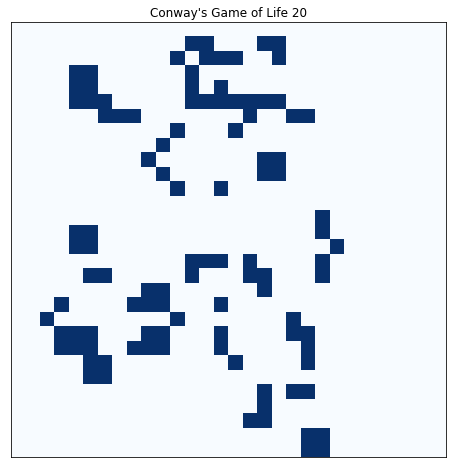

In [282]:
# Create the animation
life = Life2D(30)
Animation2D(life).animate(20)

## For Project Idea: Life Patterns
This code demonstrates how to use a "regular expression" (re) to parse run-length encoded data
 - a regular expression to parse the GoL RLE pattern

In [283]:
rle_pairs = r'(\d+)?([bo$!])'  # 2-tuples, (n, c), where n is optional positive integer and C is one of b,o,$,!
# pattern from https://conwaylife.com/patterns/gosperglidergun.rle
data = '''
24bo11b$22bobo11b$12b2o6b2o12b2o$11bo3bo4b2o12b2o$2o8bo5bo3b2o14b$2o8bo3bob2o4bobo11b$10bo5bo7bo11b$11bo3bo20b$12b2o!
'''
matches = re.findall(rle_pairs, data)
print(matches)

[('24', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('22', 'b'), ('', 'o'), ('', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('12', 'b'), ('2', 'o'), ('6', 'b'), ('2', 'o'), ('12', 'b'), ('2', 'o'), ('', '$'), ('11', 'b'), ('', 'o'), ('3', 'b'), ('', 'o'), ('4', 'b'), ('2', 'o'), ('12', 'b'), ('2', 'o'), ('', '$'), ('2', 'o'), ('8', 'b'), ('', 'o'), ('5', 'b'), ('', 'o'), ('3', 'b'), ('2', 'o'), ('14', 'b'), ('', '$'), ('2', 'o'), ('8', 'b'), ('', 'o'), ('3', 'b'), ('', 'o'), ('', 'b'), ('2', 'o'), ('4', 'b'), ('', 'o'), ('', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('10', 'b'), ('', 'o'), ('5', 'b'), ('', 'o'), ('7', 'b'), ('', 'o'), ('11', 'b'), ('', '$'), ('11', 'b'), ('', 'o'), ('3', 'b'), ('', 'o'), ('20', 'b'), ('', '$'), ('12', 'b'), ('2', 'o'), ('', '!')]
